In [56]:
# Import libraries

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import statsmodels.api as sm
from scipy.stats import shapiro
from scipy.stats import chisquare
from scipy.stats import mannwhitneyu
from scipy.stats import chi2_contingency

import warnings
warnings.filterwarnings("ignore")

pd.options.mode.chained_assignment = None

In [57]:
# Load the data set

df = pd.read_csv("cookie_cats.csv")
df

,userid,version,sum_gamerounds,retention_1,retention_7
0,116,gate_30,3,False,False
1,337,gate_30,38,True,False
2,377,gate_40,165,True,False
3,483,gate_40,1,False,False
4,488,gate_40,179,True,True
...,...,...,...,...,...
90184,9999441,gate_40,97,True,False
90185,9999479,gate_40,30,False,False
90186,9999710,gate_30,28,True,False
90187,9999768,gate_40,51,True,False


In [58]:
# Cek Informasi Dataset

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90189 entries, 0 to 90188
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   userid          90189 non-null  int64 
 1   version         90189 non-null  object
 2   sum_gamerounds  90189 non-null  int64 
 3   retention_1     90189 non-null  bool  
 4   retention_7     90189 non-null  bool  
dtypes: bool(2), int64(2), object(1)
memory usage: 2.2+ MB


In [59]:
# cek data terduplikasi

df.duplicated(subset=["userid"]).any()

False

- **90189 baris data** 
- **Tidak ada nilai null** 
- **Tidak ada duplikasi userid**

In [60]:
# Drop kolom 'userid' karena tidak akan digunakan pada eksperimen ini
df.drop(columns=["userid"], inplace=True)

# Edit kolom 'version' menjadi 'group'
df.rename(columns={"version": "group"},inplace=True)
df["group"] = np.where(df.group == "gate_30", "A", "B")
df.loc[:,"group"]=df.group.astype("category")

# cek dateratas
df.head()

,group,sum_gamerounds,retention_1,retention_7
0,A,3,False,False
1,A,38,True,False
2,B,165,True,False
3,B,1,False,False
4,B,179,True,True


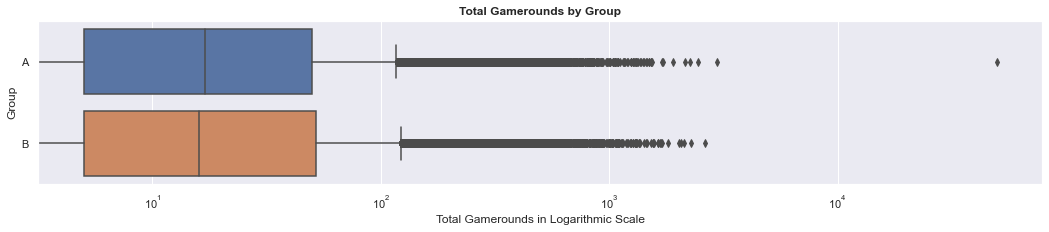

In [61]:
# Distribusi total ronde permainan dalam skala logaritma

sns.set(rc={'figure.figsize':(18,3)})
ax=sns.boxplot(y = df.group, x = df.sum_gamerounds, orient="h")
ax.set_xscale('log')
plt.title("Total Gamerounds by Group", fontweight="bold")
plt.xlabel("Total Gamerounds in Logarithmic Scale")
plt.ylabel("Group")
plt.show()

In [62]:
# Observasi pencilan/outlier
df.sum_gamerounds.sort_values(ascending = False).head()

57702    49854
7912      2961
29417     2640
43671     2438
48188     2294
Name: sum_gamerounds, dtype: int64

- **Ada satu pencilan yg sangat kentara pada index ke-57702 (yaitu 49,854 ronde)** 

In [63]:
# Hapus outlier

df= df[df["sum_gamerounds"] < 3000].reset_index()

In [64]:
# Cek total ronde permainan

df.sum_gamerounds.value_counts().head()

1    5538
2    4606
0    3994
3    3958
4    3629
Name: sum_gamerounds, dtype: int64

- **3994 sudah menginstall aplikasinya namun tidak pernah bermain sekalipun. Kemungkinan:**  
    - Aplikasinya crash atau keluar tiba-tiba  
    - Mereka memang belum mulai bermain
    - Mereka mengunduh game lain secara bersamaan dan lebih tertarik dengan yang lainnya

In [65]:
# Mereka yang tidak pernah bermain sebaiknya dihapus saja
# karena akan mempengaruhi hasil analisis statistiknya

df=df[df.sum_gamerounds != 0].reset_index()

In [66]:
# Statistika deskriptif dari dataset

df["sum_gamerounds"].describe([0.95,0.99])

count    86194.000000
mean        53.698297
std        104.425174
min          1.000000
50%         18.000000
95%        227.000000
99%        499.000000
max       2961.000000
Name: sum_gamerounds, dtype: float64

- **Setengah dari total pengguna pernah bermain sebanyak 18 kali atau kurang**

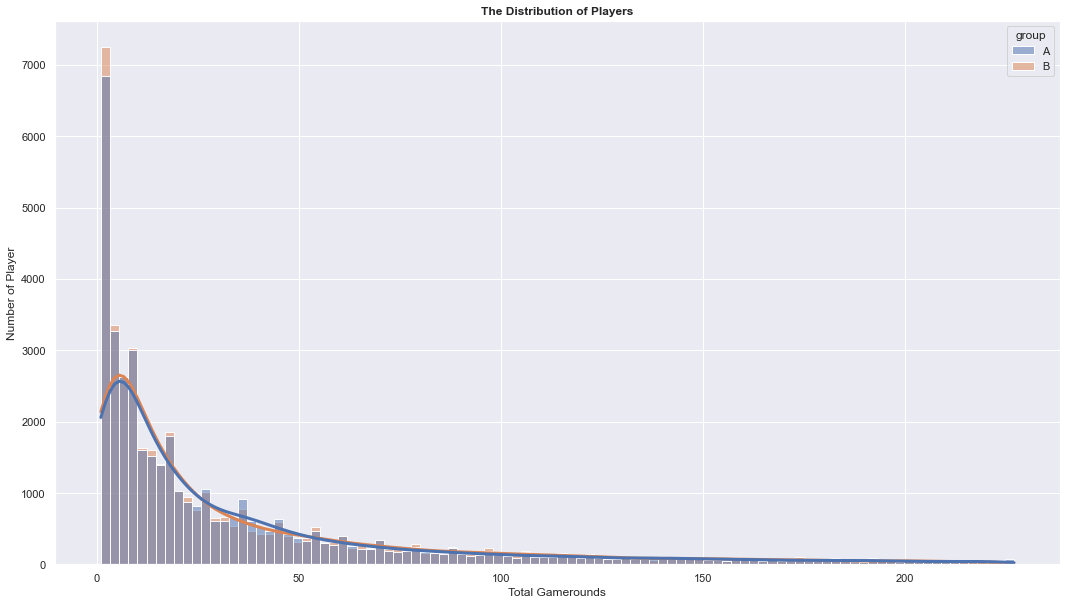

In [67]:
# 95% of players have played 227 times or less. Draw them

sns.set(rc={'figure.figsize':(18,10)})
sns.histplot(data=df[df.sum_gamerounds<228], x="sum_gamerounds", kde=True,hue="group",line_kws={"lw":3},bins=100)
plt.title("The Distribution of Players", fontweight="bold")
plt.xlabel("Total Gamerounds")
plt.ylabel("Number of Player")
plt.show()

- **As the levels progress, the number of users decreases.   Possible reasons:**    
    -Levels become boring and repetitive as they progress, possibly due to a lack of new mechanics or variation  
    -After a certain point in the game, the level difficulty increases exponentially, to the point where the game becomes unplayable without an in-app purchase

**Sample Ratio Mismatch**  


SRM is defined as the mismatch between expected sample ratio and observed sample ratio.  
For example in an A/B test with a 50/50 split, we expect the ratio between control and test sample groups to be 1.  
If we end up observing a 40/60 split, we are far from the expected ratio of 1 and we have SRM. 

<img src="https://1xeqto1j2jdz1tjsywaminn1-wpengine.netdna-ssl.com/wp-content/uploads/2021/01/image2-1.png" width="400"/>

*For more information:*  

[Diagnosing Sample Ratio Mismatch in A/B Testing](https://www.microsoft.com/en-us/research/group/experimentation-platform-exp/articles/diagnosing-sample-ratio-mismatch-in-a-b-testing/)  
[The essential guide to Sample Ratio Mismatch for your A/B tests](https://towardsdatascience.com/the-essential-guide-to-sample-ratio-mismatch-for-your-a-b-tests-96a4db81d7a4)  

In [68]:
# Function to check Sample Ratio Mismatch

def SRMcheck(df):
    num_A = df["group"].value_counts().loc["A"]
    num_B = df["group"].value_counts().loc["B"]

    print("Number of players in group A (gate_30):",num_A)
    print("Number of players in group B (gate_40):",num_B)
    print("A/B ratio: {:.5f}".format(num_A/num_B))
    print("-"*45)
    
    observed = [ num_A, num_B ]
    total_player= sum(observed)
    expected = [ total_player/2, total_player/2 ]

    chi = chisquare(observed, f_exp=expected)
    print("pvalue: {:.3f}".format(chi[1]))
    print("*"*15)
    if chi[1] < 0.01:
        print('SRM may be present.')
    else:
        print('Probably no SRM.')

In [69]:
# Check SRM

SRMcheck(df)

Number of players in group A (gate_30): 42762
Number of players in group B (gate_40): 43432
A/B ratio: 0.98457
---------------------------------------------
pvalue: 0.022
***************
Probably no SRM.


### A/B TESTING for Game Rounds

In [70]:
# Describe sum_gamerounds

df.groupby("group").sum_gamerounds.agg(["sum","mean","median"])

,sum,mean,median
group,,,
A,2294941,53.667766,18
B,2333530,53.728357,18


- **The medians of both groups are the same**  
- **The total number of games and means are slightly higher for group B**

In [71]:
# Check gamerounds difference

sum_difference= round(100*(df.query("group=='B'").sum_gamerounds.sum() - df.query("group=='A'").sum_gamerounds.sum()) 
      / df.query("group=='A'").sum_gamerounds.sum(), 2)
print("Group B played a total of {}% more games than group A".format(sum_difference))

Group B played a total of 1.68% more games than group A


**Data Distribution** 

All statistical tests can be divided into two main groups: **parametric** and **non-parametric**  
 
- **Parametric tests** are used only when a normal (or close to normal) distribution is assumed. The most commonly used tests are **Z-test**, **T-test**, and **ANOVA**  
- **Non-parametric tests** are used when continuous data is not normally distributed or when data is discrete. The most commonly used tests are **chi-squared**, **Fisher’s exact tests** and **Mann–Whitney U-test**

In [72]:
# Function to check normality (Q-Q plot and Shapiro–Wilk test)

def checkNormality(df):
    sns.set(rc={'figure.figsize':(5,5)})
    sm.qqplot(df, line='45', fit=True)
    plt.show()

    _ , p= shapiro(df)
    alpha = 0.05
    print(f"p={p}")
    if p > alpha:
        print('Sample a normal distribution')
    else:
        print('Sample is not a normal distribution')

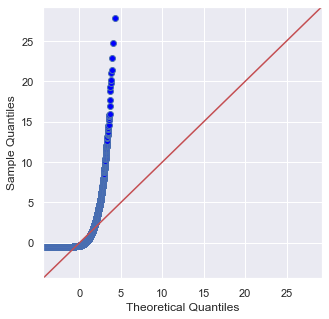

p=0.0
Sample is not a normal distribution


In [73]:
# Check normality for sum_gamerounds

checkNormality(df.sum_gamerounds)

- **Non-Parametric Test should be used since the sample is not normally distributed**

**Bootstrapping**  

Bootstrapping is any test or metric that uses random sampling with replacement (e.g. mimicking the sampling process), and falls under the broader class of resampling methods.Let's find these numbers by bootstrapping to get a precise data.  
*For more information:* [Bootstrapping](https://en.wikipedia.org/wiki/Bootstrapping_(statistics))

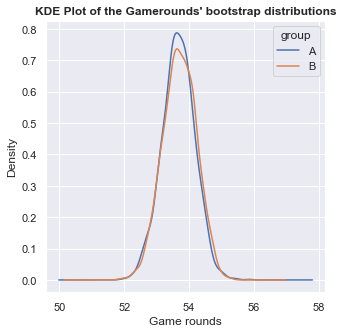

In [74]:
# Bootstraping - Create 2000 samples of dataset

bootstrap_sum=pd.DataFrame([df.sample(frac=1, replace=True).groupby('group')['sum_gamerounds'].mean() for i in range(2000)])

bootstrap_sum.plot.kde()
sns.set(rc={'figure.figsize':(18,5)})
plt.title("KDE Plot of the Gamerounds' bootstrap distributions", fontweight="bold")
plt.xlabel("Game rounds")
plt.show()

**H0 (Null hypothesis)       :** Changing the gate level has no impact on sum_gamerounds  
**H1 (Alternative hypothesis):** Changing the gate level has an impact on sum_gamerounds

In [75]:
# Function for Mann-Whitney U Test

def mannwhitneyfunc(value1,value2):

    stat, p=mannwhitneyu(sum_gamerounds1, sum_gamerounds2)

    alpha=0.05 

    print('p=%.4f , alpha=%.2f '%(p,alpha))
    if p > alpha:
        print('Two groups have no significant difference')
    else:
        print('Two groups have a significant difference')

In [76]:
#Mann-Whitney U Test for sum_gamerounds

sum_gamerounds1 = df[df.group=='A'].sum_gamerounds
sum_gamerounds2 = df[df.group=='B'].sum_gamerounds

mannwhitneyfunc(sum_gamerounds1,sum_gamerounds2)

p=0.0588 , alpha=0.05 
Two groups have no significant difference


- **No statistically significant difference between groups. They have similar sum_gamerounds.**

### A/B TESTING for Retention Rates

**H0 (Null hypothesis)       :** Changing the gate level has no impact on retention rate  
**H1 (Alternative hypothesis):** Changing the gate level has an impact on retention rate

In [77]:
# Retention rate by groups

retention_rate = df.groupby("group").agg({"retention_1":"mean","retention_7":"mean"})
retention_rate

,retention_1,retention_7
group,,
A,0.467541,0.198424
B,0.462171,0.190321


- **Both retention_1 and retention_7 are slightly higher for group A**

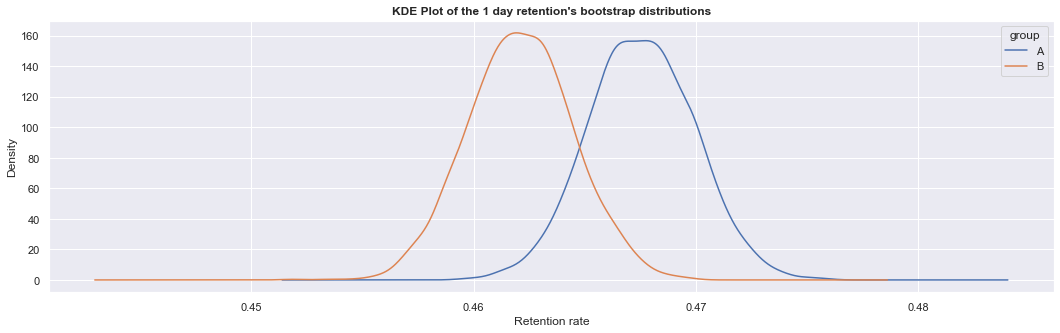

In [78]:
# Bootstraping - Create 2000 samples of dataset for retention_1 

bootstrap_retention1=pd.DataFrame([df.sample(frac=1, replace=True).groupby('group')['retention_1'].mean() for i in range(2000)])

bootstrap_retention1.plot.kde()
sns.set(rc={'figure.figsize':(18,5)})
plt.title("KDE Plot of the 1 day retention's bootstrap distributions", fontweight="bold")
plt.xlabel("Retention rate")
plt.show()

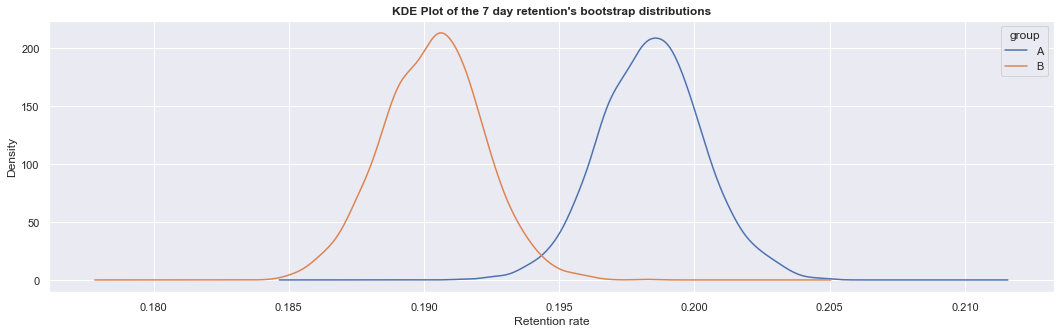

In [79]:
# Bootstraping - Create 2000 samples of dataset for retention_7

bootstrap_retention7=pd.DataFrame([df.sample(frac=1, replace=True).groupby('group')['retention_7'].mean() for i in range(2000)])

bootstrap_retention7.plot.kde()
sns.set(rc={'figure.figsize':(18,5)})
plt.title("KDE Plot of the 7 day retention's bootstrap distributions", fontweight="bold")
plt.xlabel("Retention rate")
plt.show()

In [80]:
# Function for Chi-square test of independence of variables in a contingency table

def chi2test(data):
    _, p, _, _ = chi2_contingency(data)
    alpha = 0.05

    print('p=%.4f , alpha=%.2f '%(p,alpha))
    if p > alpha:
        print('Two groups have no significant difference')
    else:
        print('Two groups have a significant difference')

In [81]:
#Chi-square test for retention_1 
cross1 = pd.crosstab(df["group"], df["retention_1"])
chi2test(cross1)

p=0.1155 , alpha=0.05 
Two groups have no significant difference


In [82]:
#Chi-square test for retention_7

cross7 = pd.crosstab(df["group"], df["retention_7"])
chi2test(cross7)

p=0.0027 , alpha=0.05 
Two groups have a significant difference


### Conclusion

- We discovered that the total number of game rounds in group B is slightly higher than the number of game rounds in group A. 
But the Mann-Whitney U Test shows that there is no statistically significant difference between the groups. So, we can say that **changing the gate of the game from level 30 to level 40 has no effect on the game rounds played by the users.**

- We observed that retention rates were slightly higher in group A. According to the chi-square test, the 1-day user retention rates are not statistically different, but the 7-day user retention rate is higher in Group A. So, we can say that **changing the gate of the game from level 30 to level 40 has negative effect on the 7-day user retention rate.**  

Possible reason why the retention is higher when the door is positioned earlier: [Hedonic treadmill](https://en.wikipedia.org/wiki/Hedonic_treadmill)  
- In a nutshell, hedonic treadmill refers to people's tendency to get less and less enjoyment from a fun activity over time if they do it repeatedly. Players' enjoyment of the game is extended by forcing them to take a break when they reach a gate. When the gate is raised to level 40, however, fewer players make it that far, and they are more likely to stop playing the game due to boredom.


### <center>It is better to keep the door at level 30</center>